In [5]:
from __future__ import print_function
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import IPython.display as ipd
import seaborn as sns

import warnings
import os
warnings.filterwarnings('ignore')

from torch import nn, optim
from torchvision import transforms, models, datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
pwd

'/home/user/shaheen.perveen/SER_new/Code/Model_Code'

In [3]:
data_dir = '/home/user/shaheen.perveen/SER_new/IEMOCAP_image_data'
model_save_path = '/home/user/shaheen.perveen/SER_new/saved_models'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [6]:
batch_size = 64

In [5]:
train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
test_transforms = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [6]:
trainset = datasets.ImageFolder(train_dir,transform=train_transforms)
testset = datasets.ImageFolder(test_dir,transform=test_transforms)

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [8]:
print(len(testloader.dataset))

894


In [9]:
print(len(trainloader.dataset))

3598


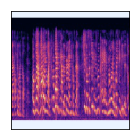

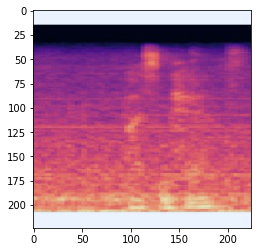

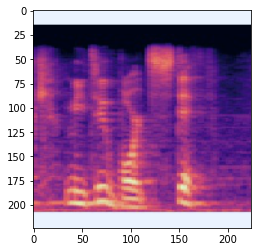

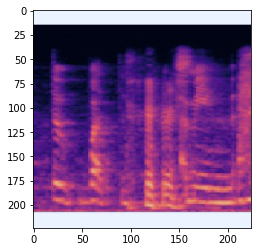

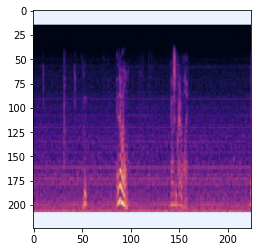

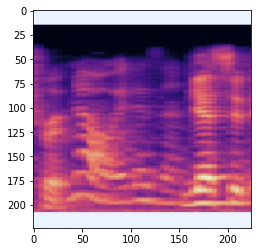

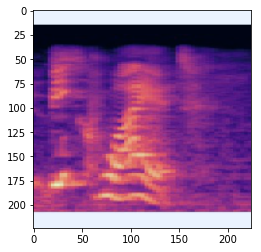

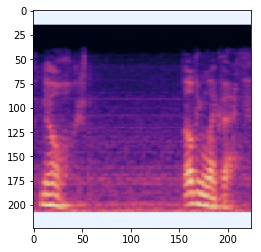

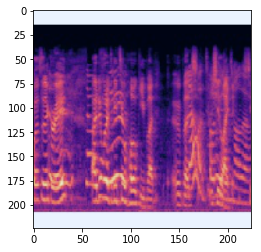

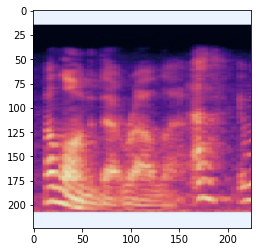

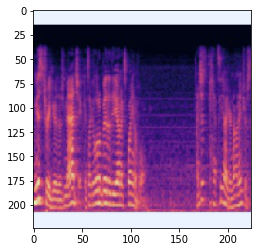

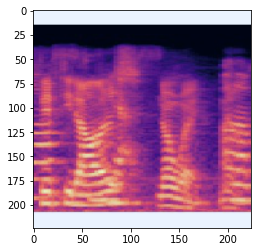

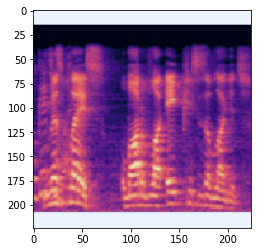

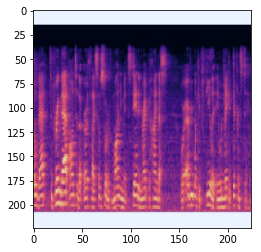

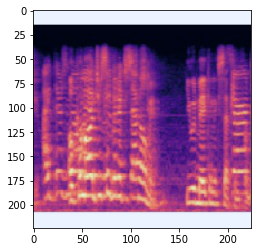

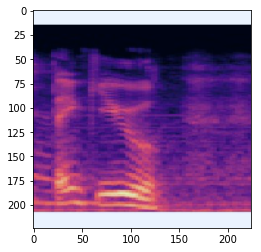

In [10]:
# def scale(x, out_range=(-1, 1)):
#     domain = np.min(x), np.max(x)
#     y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
#     return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

def scale(x):
    return (x - np.min(x))/np.ptp(x)

def imshow(img):
    img = scale(img)
#     print(img)
    plt.imshow(np.transpose(img, (1,2,0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(20,5))

for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    plt.show()

In [10]:
trainiter = iter(trainloader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [11]:
torch.cuda.is_available()

True

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
print(trainloader.dataset.class_to_idx)

{'anger': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3}


In [15]:
anger = 0
happiness = 0
neutral = 0
sadness = 0

for _, target in trainloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])
    
for _, target in testloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])

In [16]:
print("anger {} happiness {} neutral {} sadness {}".format(anger, happiness, neutral, sadness))

anger 1104 happiness 595 neutral 1709 sadness 1084


In [17]:
sample_weights = [1/anger, 1/happiness, 1/neutral, 1/sadness]
class_weights = torch.FloatTensor(sample_weights).cuda()
class_weights

tensor([0.0009, 0.0017, 0.0006, 0.0009], device='cuda:0')

In [12]:
keep_prob = 0.5

In [13]:


class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 224, 224, 3)
        #    Conv     -> (?, 224, 224, 16)
        #    Pool     -> (?, 112, 112, 16)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 112, 112, 16)
        #    Conv      ->(?, 112, 112, 32)
        #    Pool      ->(?, 56, 56, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 56, 56, 32)
        #    Conv      ->(?, 56, 56, 64)
        #    Pool      ->(?, 28, 28, 64)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        
        # L4 ImgIn shape=(?, 28, 28, 64)
        #    Conv      ->(?, 28, 28, 16)
        #    Pool      ->(?, 14, 14, 16)
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 16, kernel_size=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 14x14x16 inputs -> 512 outputs
        self.fc1 = torch.nn.Linear(14 * 14 * 16, 512, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
#         self.layer4 = torch.nn.Sequential(
#             self.fc1,
#             torch.nn.ReLU(),
#             torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 1024 inputs -> 512 outputs
        
        self.fc2 = torch.nn.Linear(512, 4, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters
        # L6 Final FC 512 inputs -> 4 outputs
#         self.fc3 = torch.nn.Linear(512, 4, bias=True)
#         torch.nn.init.xavier_uniform_(self.fc3.weight) # initialize parameters

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
#         print(out.size())
        out = out.view(out.size(0), -1)
#         print(out.size())# Flatten them for FC
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
#         out = self.fc3(out)
        return out


In [51]:

# Define the scaling network
class Crude_Diag(nn.Module):
    def __init__(self, in_features):
        scaling_factors = torch.rand(in_features)
        weight = torch.diag(scaling_factors)
        super(Crude_Diag, self).__init__()
        self.linear = nn.Linear(len(scaling_factors), len(scaling_factors), bias=False)
        self.linear.weight = nn.Parameter(weight)
        # print(self.linear.weight)

    def forward(self, x):
        x = self.linear(x)
        return x

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 224, 224, 3)
        #    Conv     -> (?, 224, 224, 16)
        #    Pool     -> (?, 112, 112, 16)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 112, 112, 16)
        #    Conv      ->(?, 112, 112, 32)
        #    Pool      ->(?, 56, 56, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 56, 56, 32)
        #    Conv      ->(?, 56, 56, 64)
        #    Pool      ->(?, 28, 28, 64)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        
        # L4 ImgIn shape=(?, 28, 28, 64)
        #    Conv      ->(?, 28, 28, 16)
        #    Pool      ->(?, 14, 14, 16)
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 16, kernel_size=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 14x14x16 inputs -> 512 outputs
        self.fc1 = torch.nn.Linear(14 * 14 * 16, 512, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
#         self.layer4 = torch.nn.Sequential(
#             self.fc1,
#             torch.nn.ReLU(),
#             torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 1024 inputs -> 512 outputs
        
        # Affine Layer
        self.Diag_Affine = Crude_Diag(512)
        self.test_linear = torch.nn.Linear(512,512)
        self.fc2 = torch.nn.Linear(512, 4, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters
        # L6 Final FC 512 inputs -> 4 outputs
#         self.fc3 = torch.nn.Linear(512, 4, bias=True)
#         torch.nn.init.xavier_uniform_(self.fc3.weight) # initialize parameters

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
#         print(out.size())
        out = out.view(out.size(0), -1)
#         print(out.size())# Flatten them for FC
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.Diag_Affine(out)
        # out = self.test_linear(out)
        out = self.fc2(out)
#         out = self.fc3(out)
        return out

In [52]:
# Create an instance of the scaling network
scale_net = Crude_Diag(4)

# Scale some input data
input = torch.tensor([[1.0, 2.0, 3.0,4.0]])
scaled_input = scale_net(input)

# Print the scaled input
print(scaled_input)

tensor([[0.3441, 0.4639, 0.7231, 1.7453]], grad_fn=<MmBackward>)


In [53]:
model = CNN()

In [54]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=3136, out_featur

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)

In [56]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

2,157,620 total parameters.
2,157,620 training parameters.


In [277]:
labels = list(trainloader.dataset.class_to_idx.keys())
labels
#2,157,620 total parameters.

['anger', 'happiness', 'neutral', 'sadness']

In [278]:
def plot_confusion_matrix(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted, labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, annot_kws={"size": 10}, fmt='.0f'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    plt.show()

In [279]:
label_to_class = {value: key for key, value in trainloader.dataset.class_to_idx.items()}
label_to_class

{0: 'anger', 1: 'happiness', 2: 'neutral', 3: 'sadness'}

In [280]:
def train(epoch, model):
    model.train()
    correct_train = 0
    train_loss = 0
    train_acc = 0
    
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        # zero the gradient, forward, backward and running pytorch rhythm
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct_train += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    
    train_loss /= len(trainloader.dataset)
    train_acc = 100. * correct_train / len(trainloader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(train_loss))
    print('\nTrain Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct_train, len(trainloader.dataset), 100. * correct_train / len(trainloader.dataset)))
    
    return train_loss, int(train_acc.numpy())
            

In [281]:
def test(model):
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    history_test = []

    pred_model = []
    actual = []

    for data, target in testloader:
        data, target = data.to(device), target.to(device)

        # output from model
        output = model(data)

        # sum total loss
        test_loss += criterion(output, target).item()

        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        pred_model.append(pred.cpu().numpy())
        actual.append(target.data.cpu().numpy())


    test_loss /= len(testloader.dataset)
    test_acc = 100. * correct / len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


    pred_with_label = [label_to_class[label] for label in list(np.concatenate(pred_model))]
    actual_with_label = [label_to_class[label] for label in list(np.concatenate(actual))]

    plot_confusion_matrix(actual_with_label, pred_with_label, labels)

    print('\n Classification Report \n {} \n'.format(classification_report(actual_with_label, pred_with_label)))

    return test_loss, int(test_acc.numpy())

Train Epoch: 1 [0/3598 (0%)]	Loss: 1.933413

Train Epoch: 1 [640/3598 (18%)]	Loss: 1.449047

Train Epoch: 1 [1280/3598 (35%)]	Loss: 1.408626

Train Epoch: 1 [1920/3598 (53%)]	Loss: 1.425556

Train Epoch: 1 [2560/3598 (70%)]	Loss: 1.377837

Train Epoch: 1 [3200/3598 (88%)]	Loss: 1.421405


Train set: Average loss: 0.0235


Train Accuracy: 912/3598 (25%)


Test set: Average loss: 0.0217, Accuracy: 314/894 (35%)



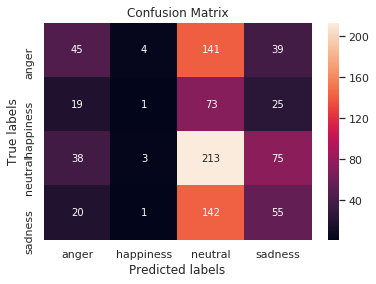


 Classification Report 
              precision    recall  f1-score   support

      anger       0.37      0.20      0.26       229
  happiness       0.11      0.01      0.02       118
    neutral       0.37      0.65      0.47       329
    sadness       0.28      0.25      0.27       218

avg / total       0.32      0.35      0.31       894
 

Train Epoch: 2 [0/3598 (0%)]	Loss: 1.401913

Train Epoch: 2 [640/3598 (18%)]	Loss: 1.402597

Train Epoch: 2 [1280/3598 (35%)]	Loss: 1.390529

Train Epoch: 2 [1920/3598 (53%)]	Loss: 1.406906

Train Epoch: 2 [2560/3598 (70%)]	Loss: 1.362150

Train Epoch: 2 [3200/3598 (88%)]	Loss: 1.415990


Train set: Average loss: 0.0221


Train Accuracy: 892/3598 (24%)


Test set: Average loss: 0.0217, Accuracy: 268/894 (29%)



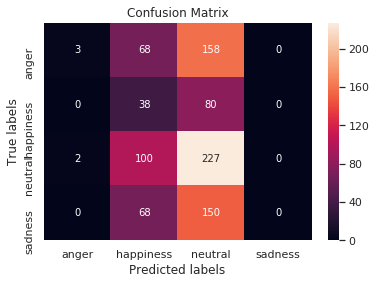


 Classification Report 
              precision    recall  f1-score   support

      anger       0.60      0.01      0.03       229
  happiness       0.14      0.32      0.19       118
    neutral       0.37      0.69      0.48       329
    sadness       0.00      0.00      0.00       218

avg / total       0.31      0.30      0.21       894
 

Train Epoch: 3 [0/3598 (0%)]	Loss: 1.375803

Train Epoch: 3 [640/3598 (18%)]	Loss: 1.361710

Train Epoch: 3 [1280/3598 (35%)]	Loss: 1.388042

Train Epoch: 3 [1920/3598 (53%)]	Loss: 1.391844

Train Epoch: 3 [2560/3598 (70%)]	Loss: 1.391923

Train Epoch: 3 [3200/3598 (88%)]	Loss: 1.402136


Train set: Average loss: 0.0220


Train Accuracy: 961/3598 (26%)


Test set: Average loss: 0.0217, Accuracy: 312/894 (34%)



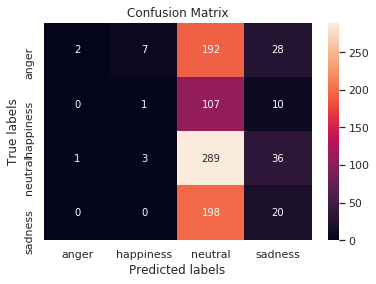


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.01      0.02       229
  happiness       0.09      0.01      0.02       118
    neutral       0.37      0.88      0.52       329
    sadness       0.21      0.09      0.13       218

avg / total       0.37      0.35      0.23       894
 

Train Epoch: 4 [0/3598 (0%)]	Loss: 1.391516

Train Epoch: 4 [640/3598 (18%)]	Loss: 1.374439

Train Epoch: 4 [1280/3598 (35%)]	Loss: 1.406129

Train Epoch: 4 [1920/3598 (53%)]	Loss: 1.383846

Train Epoch: 4 [2560/3598 (70%)]	Loss: 1.380759

Train Epoch: 4 [3200/3598 (88%)]	Loss: 1.373431


Train set: Average loss: 0.0219


Train Accuracy: 1027/3598 (28%)


Test set: Average loss: 0.0217, Accuracy: 272/894 (30%)



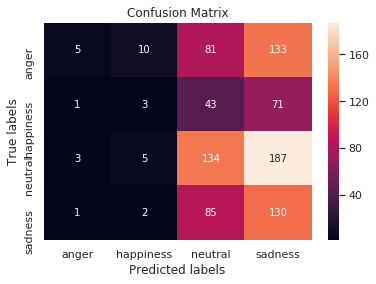


 Classification Report 
              precision    recall  f1-score   support

      anger       0.50      0.02      0.04       229
  happiness       0.15      0.03      0.04       118
    neutral       0.39      0.41      0.40       329
    sadness       0.25      0.60      0.35       218

avg / total       0.35      0.30      0.25       894
 

Train Epoch: 5 [0/3598 (0%)]	Loss: 1.376265

Train Epoch: 5 [640/3598 (18%)]	Loss: 1.401071

Train Epoch: 5 [1280/3598 (35%)]	Loss: 1.389475

Train Epoch: 5 [1920/3598 (53%)]	Loss: 1.380358

Train Epoch: 5 [2560/3598 (70%)]	Loss: 1.409716

Train Epoch: 5 [3200/3598 (88%)]	Loss: 1.387828


Train set: Average loss: 0.0219


Train Accuracy: 985/3598 (27%)


Test set: Average loss: 0.0217, Accuracy: 263/894 (29%)



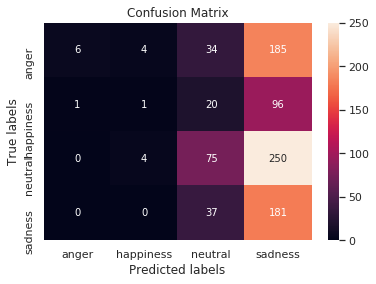


 Classification Report 
              precision    recall  f1-score   support

      anger       0.86      0.03      0.05       229
  happiness       0.11      0.01      0.02       118
    neutral       0.45      0.23      0.30       329
    sadness       0.25      0.83      0.39       218

avg / total       0.46      0.29      0.22       894
 

Train Epoch: 6 [0/3598 (0%)]	Loss: 1.362395

Train Epoch: 6 [640/3598 (18%)]	Loss: 1.372119

Train Epoch: 6 [1280/3598 (35%)]	Loss: 1.376100

Train Epoch: 6 [1920/3598 (53%)]	Loss: 1.354064

Train Epoch: 6 [2560/3598 (70%)]	Loss: 1.373141

Train Epoch: 6 [3200/3598 (88%)]	Loss: 1.407552


Train set: Average loss: 0.0218


Train Accuracy: 1013/3598 (28%)


Test set: Average loss: 0.0216, Accuracy: 269/894 (30%)



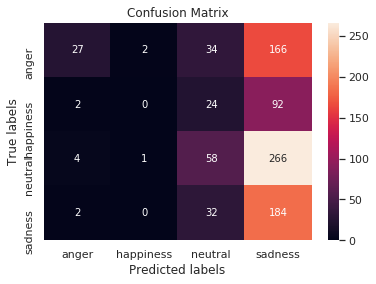


 Classification Report 
              precision    recall  f1-score   support

      anger       0.77      0.12      0.20       229
  happiness       0.00      0.00      0.00       118
    neutral       0.39      0.18      0.24       329
    sadness       0.26      0.84      0.40       218

avg / total       0.41      0.30      0.24       894
 

Train Epoch: 7 [0/3598 (0%)]	Loss: 1.319892

Train Epoch: 7 [640/3598 (18%)]	Loss: 1.356351

Train Epoch: 7 [1280/3598 (35%)]	Loss: 1.343451

Train Epoch: 7 [1920/3598 (53%)]	Loss: 1.368916

Train Epoch: 7 [2560/3598 (70%)]	Loss: 1.358163

Train Epoch: 7 [3200/3598 (88%)]	Loss: 1.392978


Train set: Average loss: 0.0217


Train Accuracy: 1221/3598 (33%)


Test set: Average loss: 0.0216, Accuracy: 218/894 (24%)



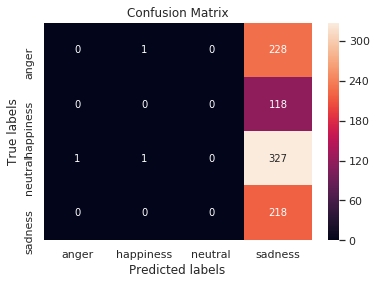


 Classification Report 
              precision    recall  f1-score   support

      anger       0.00      0.00      0.00       229
  happiness       0.00      0.00      0.00       118
    neutral       0.00      0.00      0.00       329
    sadness       0.24      1.00      0.39       218

avg / total       0.06      0.24      0.10       894
 

Train Epoch: 8 [0/3598 (0%)]	Loss: 1.369924

Train Epoch: 8 [640/3598 (18%)]	Loss: 1.396446

Train Epoch: 8 [1280/3598 (35%)]	Loss: 1.344732

Train Epoch: 8 [1920/3598 (53%)]	Loss: 1.395242

Train Epoch: 8 [2560/3598 (70%)]	Loss: 1.353189

Train Epoch: 8 [3200/3598 (88%)]	Loss: 1.326163


Train set: Average loss: 0.0214


Train Accuracy: 1196/3598 (33%)


Test set: Average loss: 0.0215, Accuracy: 289/894 (32%)



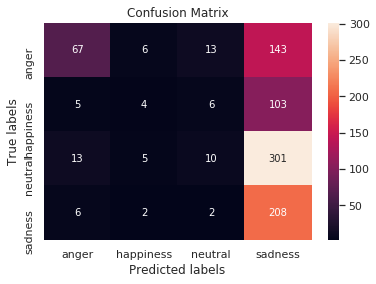


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.29      0.42       229
  happiness       0.24      0.03      0.06       118
    neutral       0.32      0.03      0.06       329
    sadness       0.28      0.95      0.43       218

avg / total       0.41      0.32      0.24       894
 

Train Epoch: 9 [0/3598 (0%)]	Loss: 1.300084

Train Epoch: 9 [640/3598 (18%)]	Loss: 1.296012

Train Epoch: 9 [1280/3598 (35%)]	Loss: 1.380961

Train Epoch: 9 [1920/3598 (53%)]	Loss: 1.312855

Train Epoch: 9 [2560/3598 (70%)]	Loss: 1.373025

Train Epoch: 9 [3200/3598 (88%)]	Loss: 1.310544


Train set: Average loss: 0.0210


Train Accuracy: 1237/3598 (34%)


Test set: Average loss: 0.0212, Accuracy: 309/894 (34%)



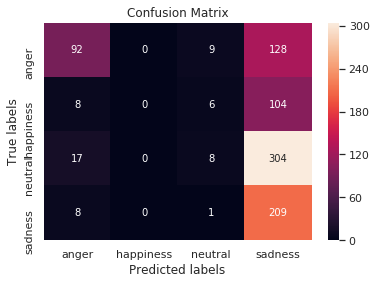


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.40      0.52       229
  happiness       0.00      0.00      0.00       118
    neutral       0.33      0.02      0.05       329
    sadness       0.28      0.96      0.43       218

avg / total       0.38      0.35      0.26       894
 

Train Epoch: 10 [0/3598 (0%)]	Loss: 1.396378

Train Epoch: 10 [640/3598 (18%)]	Loss: 1.258622

Train Epoch: 10 [1280/3598 (35%)]	Loss: 1.311335

Train Epoch: 10 [1920/3598 (53%)]	Loss: 1.279944

Train Epoch: 10 [2560/3598 (70%)]	Loss: 1.293239

Train Epoch: 10 [3200/3598 (88%)]	Loss: 1.311227


Train set: Average loss: 0.0206


Train Accuracy: 1374/3598 (38%)


Test set: Average loss: 0.0209, Accuracy: 311/894 (34%)



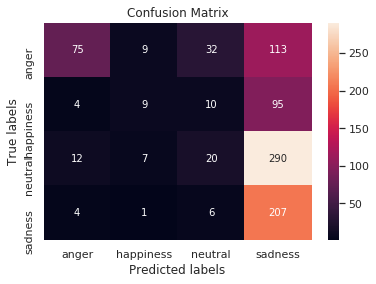


 Classification Report 
              precision    recall  f1-score   support

      anger       0.79      0.33      0.46       229
  happiness       0.35      0.08      0.12       118
    neutral       0.29      0.06      0.10       329
    sadness       0.29      0.95      0.45       218

avg / total       0.43      0.35      0.28       894
 

Train Epoch: 11 [0/3598 (0%)]	Loss: 1.340045

Train Epoch: 11 [640/3598 (18%)]	Loss: 1.444913

Train Epoch: 11 [1280/3598 (35%)]	Loss: 1.307567

Train Epoch: 11 [1920/3598 (53%)]	Loss: 1.276818

Train Epoch: 11 [2560/3598 (70%)]	Loss: 1.157326

Train Epoch: 11 [3200/3598 (88%)]	Loss: 1.255144


Train set: Average loss: 0.0199


Train Accuracy: 1449/3598 (40%)


Test set: Average loss: 0.0203, Accuracy: 377/894 (42%)



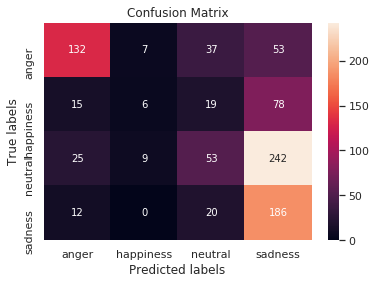


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.58      0.64       229
  happiness       0.27      0.05      0.09       118
    neutral       0.41      0.16      0.23       329
    sadness       0.33      0.85      0.48       218

avg / total       0.45      0.42      0.38       894
 

Train Epoch: 12 [0/3598 (0%)]	Loss: 1.343942

Train Epoch: 12 [640/3598 (18%)]	Loss: 1.175224

Train Epoch: 12 [1280/3598 (35%)]	Loss: 1.224311

Train Epoch: 12 [1920/3598 (53%)]	Loss: 1.264547

Train Epoch: 12 [2560/3598 (70%)]	Loss: 1.212576

Train Epoch: 12 [3200/3598 (88%)]	Loss: 1.171889


Train set: Average loss: 0.0198


Train Accuracy: 1495/3598 (41%)


Test set: Average loss: 0.0203, Accuracy: 392/894 (43%)



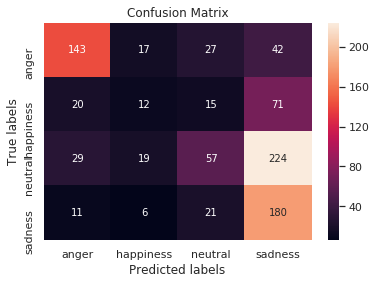


 Classification Report 
              precision    recall  f1-score   support

      anger       0.70      0.62      0.66       229
  happiness       0.22      0.10      0.14       118
    neutral       0.47      0.17      0.25       329
    sadness       0.35      0.83      0.49       218

avg / total       0.47      0.44      0.40       894
 

Train Epoch: 13 [0/3598 (0%)]	Loss: 1.288565

Train Epoch: 13 [640/3598 (18%)]	Loss: 1.338328

Train Epoch: 13 [1280/3598 (35%)]	Loss: 1.206943

Train Epoch: 13 [1920/3598 (53%)]	Loss: 1.264509

Train Epoch: 13 [2560/3598 (70%)]	Loss: 1.169113

Train Epoch: 13 [3200/3598 (88%)]	Loss: 1.187126


Train set: Average loss: 0.0196


Train Accuracy: 1461/3598 (40%)


Test set: Average loss: 0.0200, Accuracy: 409/894 (45%)



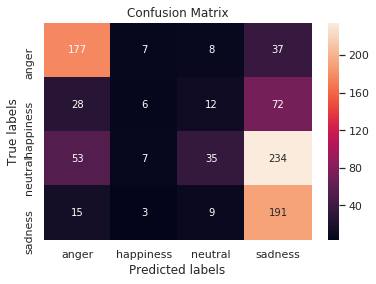


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.77      0.71       229
  happiness       0.26      0.05      0.09       118
    neutral       0.55      0.11      0.18       329
    sadness       0.36      0.88      0.51       218

avg / total       0.49      0.46      0.38       894
 

Train Epoch: 14 [0/3598 (0%)]	Loss: 1.220141

Train Epoch: 14 [640/3598 (18%)]	Loss: 1.193362

Train Epoch: 14 [1280/3598 (35%)]	Loss: 1.258211

Train Epoch: 14 [1920/3598 (53%)]	Loss: 1.322034

Train Epoch: 14 [2560/3598 (70%)]	Loss: 1.095531

Train Epoch: 14 [3200/3598 (88%)]	Loss: 1.147825


Train set: Average loss: 0.0190


Train Accuracy: 1519/3598 (42%)


Test set: Average loss: 0.0197, Accuracy: 410/894 (45%)



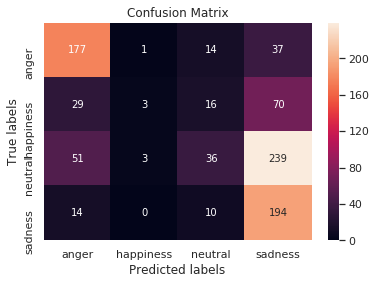


 Classification Report 
              precision    recall  f1-score   support

      anger       0.65      0.77      0.71       229
  happiness       0.43      0.03      0.05       118
    neutral       0.47      0.11      0.18       329
    sadness       0.36      0.89      0.51       218

avg / total       0.49      0.46      0.38       894
 

Train Epoch: 15 [0/3598 (0%)]	Loss: 1.284531

Train Epoch: 15 [640/3598 (18%)]	Loss: 1.201107

Train Epoch: 15 [1280/3598 (35%)]	Loss: 1.312402

Train Epoch: 15 [1920/3598 (53%)]	Loss: 1.199633

Train Epoch: 15 [2560/3598 (70%)]	Loss: 1.179636

Train Epoch: 15 [3200/3598 (88%)]	Loss: 1.274810


Train set: Average loss: 0.0192


Train Accuracy: 1584/3598 (44%)


Test set: Average loss: 0.0196, Accuracy: 400/894 (44%)



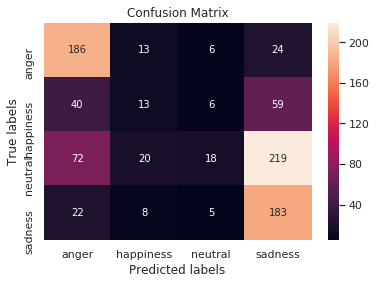


 Classification Report 
              precision    recall  f1-score   support

      anger       0.58      0.81      0.68       229
  happiness       0.24      0.11      0.15       118
    neutral       0.51      0.05      0.10       329
    sadness       0.38      0.84      0.52       218

avg / total       0.46      0.45      0.36       894
 

Train Epoch: 16 [0/3598 (0%)]	Loss: 1.008729

Train Epoch: 16 [640/3598 (18%)]	Loss: 1.210450

Train Epoch: 16 [1280/3598 (35%)]	Loss: 1.099261

Train Epoch: 16 [1920/3598 (53%)]	Loss: 1.143888

Train Epoch: 16 [2560/3598 (70%)]	Loss: 1.059712

Train Epoch: 16 [3200/3598 (88%)]	Loss: 1.174557


Train set: Average loss: 0.0188


Train Accuracy: 1574/3598 (43%)


Test set: Average loss: 0.0196, Accuracy: 407/894 (45%)



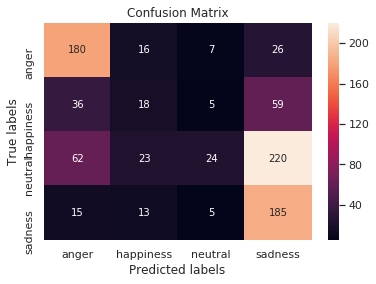


 Classification Report 
              precision    recall  f1-score   support

      anger       0.61      0.79      0.69       229
  happiness       0.26      0.15      0.19       118
    neutral       0.59      0.07      0.13       329
    sadness       0.38      0.85      0.52       218

avg / total       0.50      0.46      0.38       894
 

Train Epoch: 17 [0/3598 (0%)]	Loss: 1.209988

Train Epoch: 17 [640/3598 (18%)]	Loss: 1.305050

Train Epoch: 17 [1280/3598 (35%)]	Loss: 1.071514

Train Epoch: 17 [1920/3598 (53%)]	Loss: 1.151172

Train Epoch: 17 [2560/3598 (70%)]	Loss: 1.226281

Train Epoch: 17 [3200/3598 (88%)]	Loss: 1.170169


Train set: Average loss: 0.0189


Train Accuracy: 1617/3598 (44%)


Test set: Average loss: 0.0196, Accuracy: 400/894 (44%)



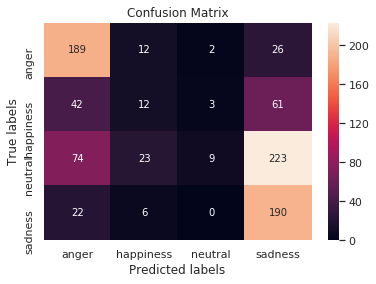


 Classification Report 
              precision    recall  f1-score   support

      anger       0.58      0.83      0.68       229
  happiness       0.23      0.10      0.14       118
    neutral       0.64      0.03      0.05       329
    sadness       0.38      0.87      0.53       218

avg / total       0.51      0.45      0.34       894
 

Train Epoch: 18 [0/3598 (0%)]	Loss: 1.320372

Train Epoch: 18 [640/3598 (18%)]	Loss: 1.204473

Train Epoch: 18 [1280/3598 (35%)]	Loss: 1.241787

Train Epoch: 18 [1920/3598 (53%)]	Loss: 1.256559

Train Epoch: 18 [2560/3598 (70%)]	Loss: 1.178171

Train Epoch: 18 [3200/3598 (88%)]	Loss: 1.230036


Train set: Average loss: 0.0188


Train Accuracy: 1661/3598 (46%)


Test set: Average loss: 0.0194, Accuracy: 410/894 (45%)



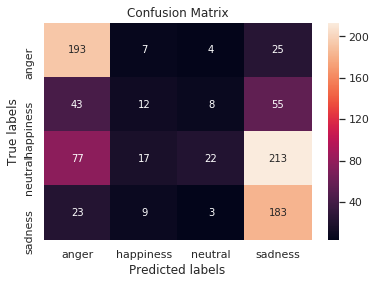


 Classification Report 
              precision    recall  f1-score   support

      anger       0.57      0.84      0.68       229
  happiness       0.27      0.10      0.15       118
    neutral       0.59      0.07      0.12       329
    sadness       0.38      0.84      0.53       218

avg / total       0.49      0.46      0.37       894
 

Train Epoch: 19 [0/3598 (0%)]	Loss: 1.130679

Train Epoch: 19 [640/3598 (18%)]	Loss: 1.162004

Train Epoch: 19 [1280/3598 (35%)]	Loss: 1.185920

Train Epoch: 19 [1920/3598 (53%)]	Loss: 1.149646

Train Epoch: 19 [2560/3598 (70%)]	Loss: 1.129337

Train Epoch: 19 [3200/3598 (88%)]	Loss: 1.108128


Train set: Average loss: 0.0185


Train Accuracy: 1648/3598 (45%)


Test set: Average loss: 0.0193, Accuracy: 419/894 (46%)



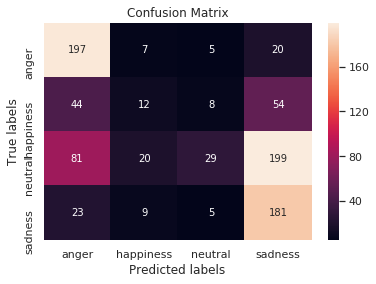


 Classification Report 
              precision    recall  f1-score   support

      anger       0.57      0.86      0.69       229
  happiness       0.25      0.10      0.14       118
    neutral       0.62      0.09      0.15       329
    sadness       0.40      0.83      0.54       218

avg / total       0.50      0.47      0.38       894
 

Train Epoch: 20 [0/3598 (0%)]	Loss: 1.141878

Train Epoch: 20 [640/3598 (18%)]	Loss: 1.044023

Train Epoch: 20 [1280/3598 (35%)]	Loss: 1.140066

Train Epoch: 20 [1920/3598 (53%)]	Loss: 1.059196

Train Epoch: 20 [2560/3598 (70%)]	Loss: 1.153605

Train Epoch: 20 [3200/3598 (88%)]	Loss: 1.135999


Train set: Average loss: 0.0185


Train Accuracy: 1671/3598 (46%)


Test set: Average loss: 0.0194, Accuracy: 402/894 (44%)



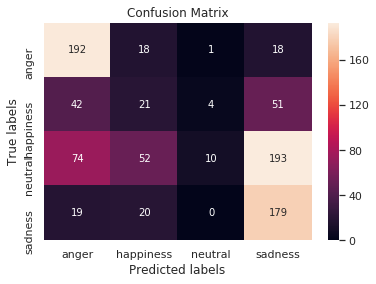


 Classification Report 
              precision    recall  f1-score   support

      anger       0.59      0.84      0.69       229
  happiness       0.19      0.18      0.18       118
    neutral       0.67      0.03      0.06       329
    sadness       0.41      0.82      0.54       218

avg / total       0.52      0.45      0.35       894
 

Train Epoch: 21 [0/3598 (0%)]	Loss: 1.099914

Train Epoch: 21 [640/3598 (18%)]	Loss: 1.086019

Train Epoch: 21 [1280/3598 (35%)]	Loss: 1.062081

Train Epoch: 21 [1920/3598 (53%)]	Loss: 1.199412

Train Epoch: 21 [2560/3598 (70%)]	Loss: 1.108958

Train Epoch: 21 [3200/3598 (88%)]	Loss: 1.249566


Train set: Average loss: 0.0184


Train Accuracy: 1641/3598 (45%)


Test set: Average loss: 0.0197, Accuracy: 388/894 (43%)



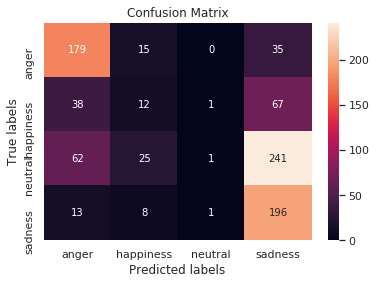


 Classification Report 
              precision    recall  f1-score   support

      anger       0.61      0.78      0.69       229
  happiness       0.20      0.10      0.13       118
    neutral       0.33      0.00      0.01       329
    sadness       0.36      0.90      0.52       218

avg / total       0.39      0.43      0.32       894
 

Train Epoch: 22 [0/3598 (0%)]	Loss: 1.245692

Train Epoch: 22 [640/3598 (18%)]	Loss: 1.138782

Train Epoch: 22 [1280/3598 (35%)]	Loss: 1.314596

Train Epoch: 22 [1920/3598 (53%)]	Loss: 1.189679

Train Epoch: 22 [2560/3598 (70%)]	Loss: 1.276247

Train Epoch: 22 [3200/3598 (88%)]	Loss: 1.066906


Train set: Average loss: 0.0184


Train Accuracy: 1641/3598 (45%)


Test set: Average loss: 0.0196, Accuracy: 395/894 (44%)



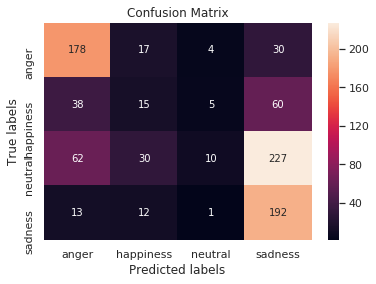


 Classification Report 
              precision    recall  f1-score   support

      anger       0.61      0.78      0.68       229
  happiness       0.20      0.13      0.16       118
    neutral       0.50      0.03      0.06       329
    sadness       0.38      0.88      0.53       218

avg / total       0.46      0.44      0.35       894
 

Train Epoch: 23 [0/3598 (0%)]	Loss: 0.979352

Train Epoch: 23 [640/3598 (18%)]	Loss: 1.137974

Train Epoch: 23 [1280/3598 (35%)]	Loss: 1.233120

Train Epoch: 23 [1920/3598 (53%)]	Loss: 1.228164

Train Epoch: 23 [2560/3598 (70%)]	Loss: 0.953938

Train Epoch: 23 [3200/3598 (88%)]	Loss: 1.181300


Train set: Average loss: 0.0181


Train Accuracy: 1714/3598 (47%)


Test set: Average loss: 0.0192, Accuracy: 420/894 (46%)



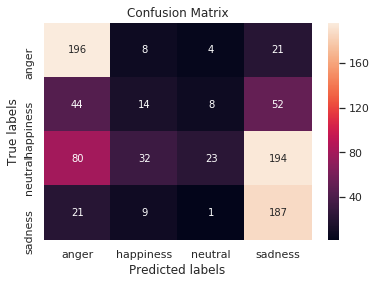


 Classification Report 
              precision    recall  f1-score   support

      anger       0.57      0.86      0.69       229
  happiness       0.22      0.12      0.15       118
    neutral       0.64      0.07      0.13       329
    sadness       0.41      0.86      0.56       218

avg / total       0.51      0.47      0.38       894
 

Train Epoch: 24 [0/3598 (0%)]	Loss: 1.177858

Train Epoch: 24 [640/3598 (18%)]	Loss: 1.176362

Train Epoch: 24 [1280/3598 (35%)]	Loss: 1.160653

Train Epoch: 24 [1920/3598 (53%)]	Loss: 1.268323

Train Epoch: 24 [2560/3598 (70%)]	Loss: 1.093090

Train Epoch: 24 [3200/3598 (88%)]	Loss: 1.133410


Train set: Average loss: 0.0181


Train Accuracy: 1704/3598 (47%)


Test set: Average loss: 0.0190, Accuracy: 421/894 (47%)



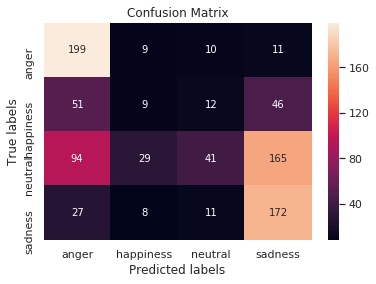


 Classification Report 
              precision    recall  f1-score   support

      anger       0.54      0.87      0.66       229
  happiness       0.16      0.08      0.10       118
    neutral       0.55      0.12      0.20       329
    sadness       0.44      0.79      0.56       218

avg / total       0.47      0.47      0.40       894
 

Train Epoch: 25 [0/3598 (0%)]	Loss: 1.311269

Train Epoch: 25 [640/3598 (18%)]	Loss: 1.250362

Train Epoch: 25 [1280/3598 (35%)]	Loss: 1.028152

Train Epoch: 25 [1920/3598 (53%)]	Loss: 1.128424

Train Epoch: 25 [2560/3598 (70%)]	Loss: 1.028997

Train Epoch: 25 [3200/3598 (88%)]	Loss: 1.165674


Train set: Average loss: 0.0183


Train Accuracy: 1694/3598 (47%)


Test set: Average loss: 0.0193, Accuracy: 412/894 (46%)



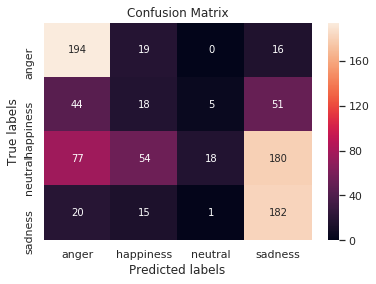


 Classification Report 
              precision    recall  f1-score   support

      anger       0.58      0.85      0.69       229
  happiness       0.17      0.15      0.16       118
    neutral       0.75      0.05      0.10       329
    sadness       0.42      0.83      0.56       218

avg / total       0.55      0.46      0.37       894
 

Train Epoch: 26 [0/3598 (0%)]	Loss: 1.143074

Train Epoch: 26 [640/3598 (18%)]	Loss: 1.111760

Train Epoch: 26 [1280/3598 (35%)]	Loss: 1.131682

Train Epoch: 26 [1920/3598 (53%)]	Loss: 1.268802

Train Epoch: 26 [2560/3598 (70%)]	Loss: 1.081007

Train Epoch: 26 [3200/3598 (88%)]	Loss: 1.136582


Train set: Average loss: 0.0181


Train Accuracy: 1710/3598 (47%)


Test set: Average loss: 0.0192, Accuracy: 427/894 (47%)



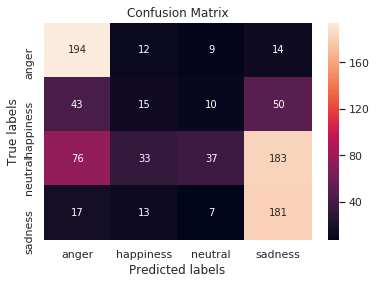


 Classification Report 
              precision    recall  f1-score   support

      anger       0.59      0.85      0.69       229
  happiness       0.21      0.13      0.16       118
    neutral       0.59      0.11      0.19       329
    sadness       0.42      0.83      0.56       218

avg / total       0.50      0.48      0.40       894
 

Train Epoch: 27 [0/3598 (0%)]	Loss: 1.176470

Train Epoch: 27 [640/3598 (18%)]	Loss: 1.173326

Train Epoch: 27 [1280/3598 (35%)]	Loss: 1.062972

Train Epoch: 27 [1920/3598 (53%)]	Loss: 1.206779

Train Epoch: 27 [2560/3598 (70%)]	Loss: 1.115837

Train Epoch: 27 [3200/3598 (88%)]	Loss: 1.091779


Train set: Average loss: 0.0180


Train Accuracy: 1703/3598 (47%)


Test set: Average loss: 0.0189, Accuracy: 422/894 (47%)



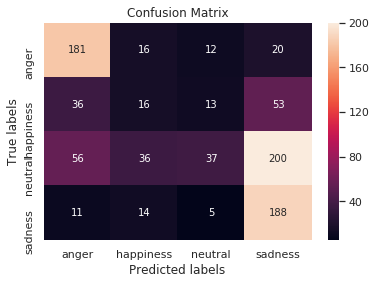


 Classification Report 
              precision    recall  f1-score   support

      anger       0.64      0.79      0.71       229
  happiness       0.20      0.14      0.16       118
    neutral       0.55      0.11      0.19       329
    sadness       0.41      0.86      0.55       218

avg / total       0.49      0.47      0.41       894
 

Train Epoch: 28 [0/3598 (0%)]	Loss: 1.230042

Train Epoch: 28 [640/3598 (18%)]	Loss: 1.061602

Train Epoch: 28 [1280/3598 (35%)]	Loss: 1.076470

Train Epoch: 28 [1920/3598 (53%)]	Loss: 1.170016

Train Epoch: 28 [2560/3598 (70%)]	Loss: 1.164186

Train Epoch: 28 [3200/3598 (88%)]	Loss: 1.184717


Train set: Average loss: 0.0181


Train Accuracy: 1721/3598 (47%)


Test set: Average loss: 0.0191, Accuracy: 421/894 (47%)



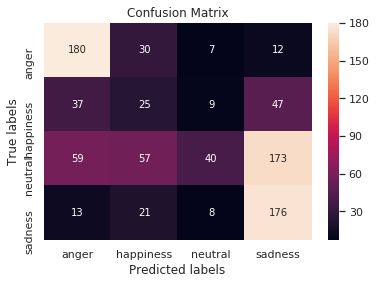


 Classification Report 
              precision    recall  f1-score   support

      anger       0.62      0.79      0.69       229
  happiness       0.19      0.21      0.20       118
    neutral       0.62      0.12      0.20       329
    sadness       0.43      0.81      0.56       218

avg / total       0.52      0.47      0.42       894
 

Train Epoch: 29 [0/3598 (0%)]	Loss: 1.122618

Train Epoch: 29 [640/3598 (18%)]	Loss: 1.221594

Train Epoch: 29 [1280/3598 (35%)]	Loss: 1.277302

Train Epoch: 29 [1920/3598 (53%)]	Loss: 1.126487

Train Epoch: 29 [2560/3598 (70%)]	Loss: 1.191919

Train Epoch: 29 [3200/3598 (88%)]	Loss: 1.264634


Train set: Average loss: 0.0182


Train Accuracy: 1718/3598 (47%)


Test set: Average loss: 0.0191, Accuracy: 423/894 (47%)



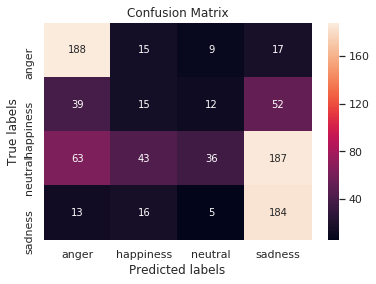


 Classification Report 
              precision    recall  f1-score   support

      anger       0.62      0.82      0.71       229
  happiness       0.17      0.13      0.14       118
    neutral       0.58      0.11      0.18       329
    sadness       0.42      0.84      0.56       218

avg / total       0.50      0.47      0.40       894
 

Train Epoch: 30 [0/3598 (0%)]	Loss: 1.149422

Train Epoch: 30 [640/3598 (18%)]	Loss: 1.066458

Train Epoch: 30 [1280/3598 (35%)]	Loss: 1.200083

Train Epoch: 30 [1920/3598 (53%)]	Loss: 1.135260

Train Epoch: 30 [2560/3598 (70%)]	Loss: 1.181229

Train Epoch: 30 [3200/3598 (88%)]	Loss: 1.158993


Train set: Average loss: 0.0180


Train Accuracy: 1764/3598 (49%)


Test set: Average loss: 0.0191, Accuracy: 419/894 (46%)



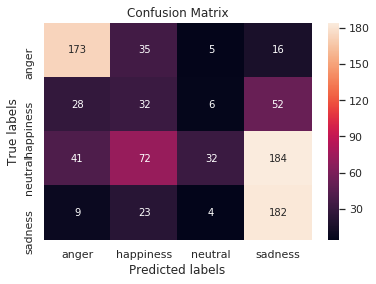


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.76      0.72       229
  happiness       0.20      0.27      0.23       118
    neutral       0.68      0.10      0.17       329
    sadness       0.42      0.83      0.56       218

avg / total       0.56      0.47      0.41       894
 

Train Epoch: 31 [0/3598 (0%)]	Loss: 1.029396

Train Epoch: 31 [640/3598 (18%)]	Loss: 1.114521

Train Epoch: 31 [1280/3598 (35%)]	Loss: 1.170200

Train Epoch: 31 [1920/3598 (53%)]	Loss: 1.048844

Train Epoch: 31 [2560/3598 (70%)]	Loss: 1.117251

Train Epoch: 31 [3200/3598 (88%)]	Loss: 1.156248


Train set: Average loss: 0.0179


Train Accuracy: 1704/3598 (47%)


Test set: Average loss: 0.0193, Accuracy: 416/894 (46%)



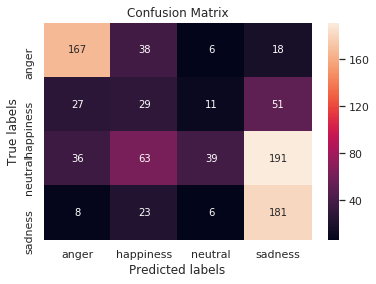


 Classification Report 
              precision    recall  f1-score   support

      anger       0.70      0.73      0.72       229
  happiness       0.19      0.25      0.21       118
    neutral       0.63      0.12      0.20       329
    sadness       0.41      0.83      0.55       218

avg / total       0.54      0.47      0.42       894
 

Train Epoch: 32 [0/3598 (0%)]	Loss: 1.237373

Train Epoch: 32 [640/3598 (18%)]	Loss: 1.186973

Train Epoch: 32 [1280/3598 (35%)]	Loss: 1.116381

Train Epoch: 32 [1920/3598 (53%)]	Loss: 1.040871

Train Epoch: 32 [2560/3598 (70%)]	Loss: 1.208454

Train Epoch: 32 [3200/3598 (88%)]	Loss: 1.135092


Train set: Average loss: 0.0179


Train Accuracy: 1750/3598 (48%)


Test set: Average loss: 0.0192, Accuracy: 426/894 (47%)



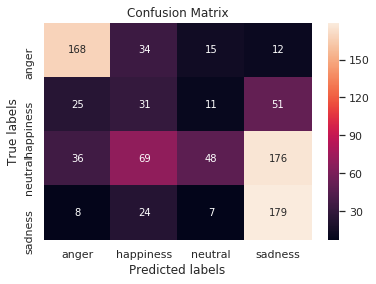


 Classification Report 
              precision    recall  f1-score   support

      anger       0.71      0.73      0.72       229
  happiness       0.20      0.26      0.22       118
    neutral       0.59      0.15      0.23       329
    sadness       0.43      0.82      0.56       218

avg / total       0.53      0.48      0.44       894
 

Train Epoch: 33 [0/3598 (0%)]	Loss: 1.134727

Train Epoch: 33 [640/3598 (18%)]	Loss: 1.178960

Train Epoch: 33 [1280/3598 (35%)]	Loss: 1.237084

Train Epoch: 33 [1920/3598 (53%)]	Loss: 1.177890

Train Epoch: 33 [2560/3598 (70%)]	Loss: 1.042046

Train Epoch: 33 [3200/3598 (88%)]	Loss: 1.201027


Train set: Average loss: 0.0178


Train Accuracy: 1756/3598 (48%)


Test set: Average loss: 0.0192, Accuracy: 423/894 (47%)



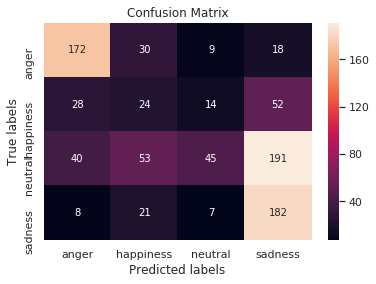


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.75      0.72       229
  happiness       0.19      0.20      0.20       118
    neutral       0.60      0.14      0.22       329
    sadness       0.41      0.83      0.55       218

avg / total       0.52      0.47      0.43       894
 

Train Epoch: 34 [0/3598 (0%)]	Loss: 1.033575

Train Epoch: 34 [640/3598 (18%)]	Loss: 1.084666

Train Epoch: 34 [1280/3598 (35%)]	Loss: 1.245410

Train Epoch: 34 [1920/3598 (53%)]	Loss: 1.213310

Train Epoch: 34 [2560/3598 (70%)]	Loss: 1.067432

Train Epoch: 34 [3200/3598 (88%)]	Loss: 1.257736


Train set: Average loss: 0.0179


Train Accuracy: 1780/3598 (49%)


Test set: Average loss: 0.0190, Accuracy: 419/894 (46%)



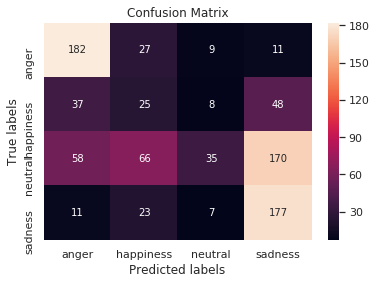


 Classification Report 
              precision    recall  f1-score   support

      anger       0.63      0.79      0.70       229
  happiness       0.18      0.21      0.19       118
    neutral       0.59      0.11      0.18       329
    sadness       0.44      0.81      0.57       218

avg / total       0.51      0.47      0.41       894
 

Train Epoch: 35 [0/3598 (0%)]	Loss: 1.120690

Train Epoch: 35 [640/3598 (18%)]	Loss: 1.147717

Train Epoch: 35 [1280/3598 (35%)]	Loss: 0.955360

Train Epoch: 35 [1920/3598 (53%)]	Loss: 1.011019

Train Epoch: 35 [2560/3598 (70%)]	Loss: 1.092986

Train Epoch: 35 [3200/3598 (88%)]	Loss: 1.259443


Train set: Average loss: 0.0177


Train Accuracy: 1746/3598 (48%)


Test set: Average loss: 0.0193, Accuracy: 415/894 (46%)



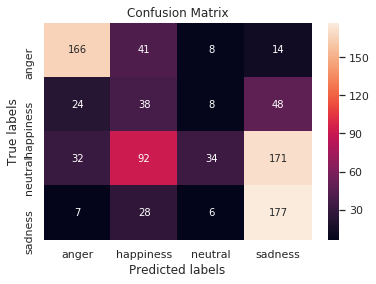


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.72      0.72       229
  happiness       0.19      0.32      0.24       118
    neutral       0.61      0.10      0.18       329
    sadness       0.43      0.81      0.56       218

avg / total       0.54      0.46      0.42       894
 

Train Epoch: 36 [0/3598 (0%)]	Loss: 1.056104

Train Epoch: 36 [640/3598 (18%)]	Loss: 1.076449

Train Epoch: 36 [1280/3598 (35%)]	Loss: 1.091916

Train Epoch: 36 [1920/3598 (53%)]	Loss: 1.112532

Train Epoch: 36 [2560/3598 (70%)]	Loss: 1.104113

Train Epoch: 36 [3200/3598 (88%)]	Loss: 0.990795


Train set: Average loss: 0.0178


Train Accuracy: 1798/3598 (49%)


Test set: Average loss: 0.0190, Accuracy: 413/894 (46%)



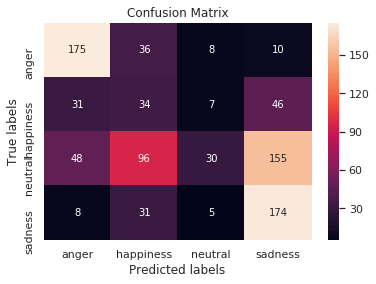


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.76      0.71       229
  happiness       0.17      0.29      0.22       118
    neutral       0.60      0.09      0.16       329
    sadness       0.45      0.80      0.58       218

avg / total       0.52      0.46      0.41       894
 

Train Epoch: 37 [0/3598 (0%)]	Loss: 1.124937

Train Epoch: 37 [640/3598 (18%)]	Loss: 1.330735

Train Epoch: 37 [1280/3598 (35%)]	Loss: 1.021879

Train Epoch: 37 [1920/3598 (53%)]	Loss: 1.152624

Train Epoch: 37 [2560/3598 (70%)]	Loss: 1.002490

Train Epoch: 37 [3200/3598 (88%)]	Loss: 1.097902


Train set: Average loss: 0.0176


Train Accuracy: 1767/3598 (49%)


Test set: Average loss: 0.0190, Accuracy: 411/894 (45%)



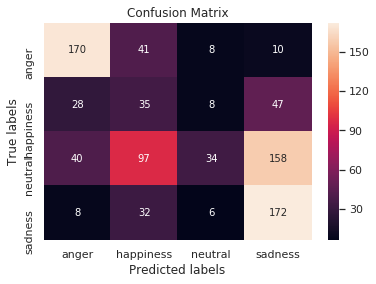


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.74      0.72       229
  happiness       0.17      0.30      0.22       118
    neutral       0.61      0.10      0.18       329
    sadness       0.44      0.79      0.57       218

avg / total       0.53      0.46      0.42       894
 

Train Epoch: 38 [0/3598 (0%)]	Loss: 1.063141

Train Epoch: 38 [640/3598 (18%)]	Loss: 1.219873

Train Epoch: 38 [1280/3598 (35%)]	Loss: 1.261377

Train Epoch: 38 [1920/3598 (53%)]	Loss: 1.044925

Train Epoch: 38 [2560/3598 (70%)]	Loss: 1.112988

Train Epoch: 38 [3200/3598 (88%)]	Loss: 1.083990


Train set: Average loss: 0.0178


Train Accuracy: 1732/3598 (48%)


Test set: Average loss: 0.0189, Accuracy: 427/894 (47%)



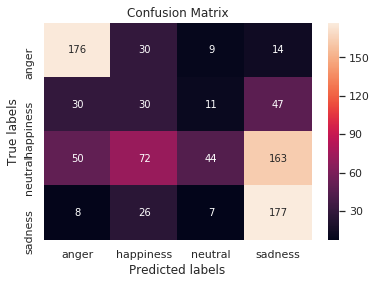


 Classification Report 
              precision    recall  f1-score   support

      anger       0.67      0.77      0.71       229
  happiness       0.19      0.25      0.22       118
    neutral       0.62      0.13      0.22       329
    sadness       0.44      0.81      0.57       218

avg / total       0.53      0.48      0.43       894
 

Train Epoch: 39 [0/3598 (0%)]	Loss: 1.235420

Train Epoch: 39 [640/3598 (18%)]	Loss: 1.085100

Train Epoch: 39 [1280/3598 (35%)]	Loss: 1.145160

Train Epoch: 39 [1920/3598 (53%)]	Loss: 0.973934

Train Epoch: 39 [2560/3598 (70%)]	Loss: 1.003505

Train Epoch: 39 [3200/3598 (88%)]	Loss: 1.101981


Train set: Average loss: 0.0178


Train Accuracy: 1782/3598 (49%)


Test set: Average loss: 0.0190, Accuracy: 399/894 (44%)



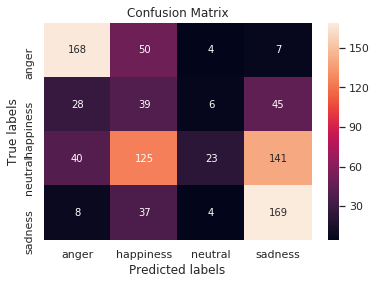


 Classification Report 
              precision    recall  f1-score   support

      anger       0.69      0.73      0.71       229
  happiness       0.16      0.33      0.21       118
    neutral       0.62      0.07      0.13       329
    sadness       0.47      0.78      0.58       218

avg / total       0.54      0.45      0.40       894
 

Train Epoch: 40 [0/3598 (0%)]	Loss: 1.163902

Train Epoch: 40 [640/3598 (18%)]	Loss: 1.089028

Train Epoch: 40 [1280/3598 (35%)]	Loss: 1.141389

Train Epoch: 40 [1920/3598 (53%)]	Loss: 1.235262

Train Epoch: 40 [2560/3598 (70%)]	Loss: 1.168964

Train Epoch: 40 [3200/3598 (88%)]	Loss: 1.097835


Train set: Average loss: 0.0177


Train Accuracy: 1784/3598 (49%)


Test set: Average loss: 0.0195, Accuracy: 399/894 (44%)



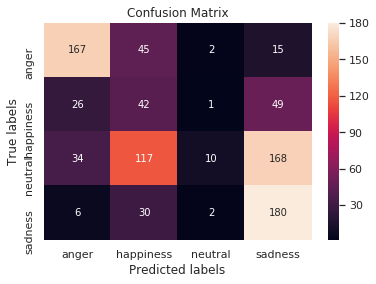


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.73      0.72       229
  happiness       0.18      0.36      0.24       118
    neutral       0.67      0.03      0.06       329
    sadness       0.44      0.83      0.57       218

avg / total       0.56      0.45      0.38       894
 

Train Epoch: 41 [0/3598 (0%)]	Loss: 1.042100

Train Epoch: 41 [640/3598 (18%)]	Loss: 1.272746

Train Epoch: 41 [1280/3598 (35%)]	Loss: 1.010665

Train Epoch: 41 [1920/3598 (53%)]	Loss: 1.242714

Train Epoch: 41 [2560/3598 (70%)]	Loss: 1.097527

Train Epoch: 41 [3200/3598 (88%)]	Loss: 1.301242


Train set: Average loss: 0.0177


Train Accuracy: 1760/3598 (48%)


Test set: Average loss: 0.0194, Accuracy: 409/894 (45%)



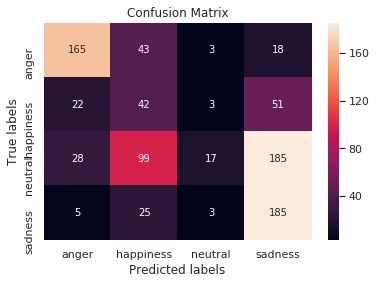


 Classification Report 
              precision    recall  f1-score   support

      anger       0.75      0.72      0.73       229
  happiness       0.20      0.36      0.26       118
    neutral       0.65      0.05      0.10       329
    sadness       0.42      0.85      0.56       218

avg / total       0.56      0.46      0.39       894
 

Train Epoch: 42 [0/3598 (0%)]	Loss: 1.345626

Train Epoch: 42 [640/3598 (18%)]	Loss: 1.185467

Train Epoch: 42 [1280/3598 (35%)]	Loss: 1.209208

Train Epoch: 42 [1920/3598 (53%)]	Loss: 1.054207

Train Epoch: 42 [2560/3598 (70%)]	Loss: 1.141668

Train Epoch: 42 [3200/3598 (88%)]	Loss: 1.088738


Train set: Average loss: 0.0176


Train Accuracy: 1805/3598 (50%)


Test set: Average loss: 0.0192, Accuracy: 397/894 (44%)



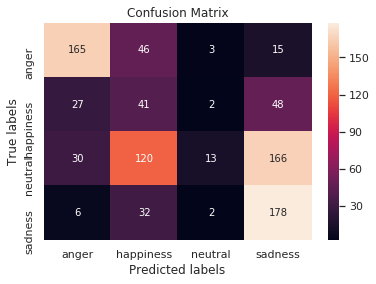


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.72      0.72       229
  happiness       0.17      0.35      0.23       118
    neutral       0.65      0.04      0.07       329
    sadness       0.44      0.82      0.57       218

avg / total       0.55      0.44      0.38       894
 

Train Epoch: 43 [0/3598 (0%)]	Loss: 1.161069

Train Epoch: 43 [640/3598 (18%)]	Loss: 1.023098

Train Epoch: 43 [1280/3598 (35%)]	Loss: 1.043849

Train Epoch: 43 [1920/3598 (53%)]	Loss: 1.087019

Train Epoch: 43 [2560/3598 (70%)]	Loss: 1.137600

Train Epoch: 43 [3200/3598 (88%)]	Loss: 1.158221


Train set: Average loss: 0.0176


Train Accuracy: 1771/3598 (49%)


Test set: Average loss: 0.0194, Accuracy: 390/894 (43%)



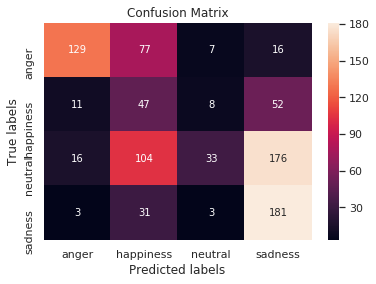


 Classification Report 
              precision    recall  f1-score   support

      anger       0.81      0.56      0.66       229
  happiness       0.18      0.40      0.25       118
    neutral       0.65      0.10      0.17       329
    sadness       0.43      0.83      0.56       218

avg / total       0.57      0.44      0.40       894
 

Train Epoch: 44 [0/3598 (0%)]	Loss: 1.067676

Train Epoch: 44 [640/3598 (18%)]	Loss: 1.110263

Train Epoch: 44 [1280/3598 (35%)]	Loss: 1.059763

Train Epoch: 44 [1920/3598 (53%)]	Loss: 1.156452

Train Epoch: 44 [2560/3598 (70%)]	Loss: 1.026641

Train Epoch: 44 [3200/3598 (88%)]	Loss: 1.287195


Train set: Average loss: 0.0176


Train Accuracy: 1814/3598 (50%)


Test set: Average loss: 0.0191, Accuracy: 401/894 (44%)



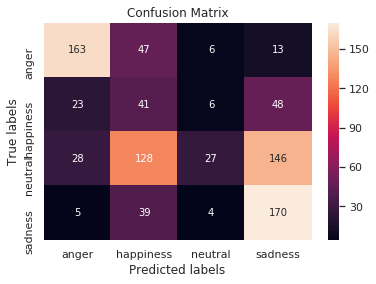


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.71      0.73       229
  happiness       0.16      0.35      0.22       118
    neutral       0.63      0.08      0.15       329
    sadness       0.45      0.78      0.57       218

avg / total       0.55      0.45      0.41       894
 

Train Epoch: 45 [0/3598 (0%)]	Loss: 1.301614

Train Epoch: 45 [640/3598 (18%)]	Loss: 1.098023

Train Epoch: 45 [1280/3598 (35%)]	Loss: 1.032977

Train Epoch: 45 [1920/3598 (53%)]	Loss: 1.122718

Train Epoch: 45 [2560/3598 (70%)]	Loss: 1.231827

Train Epoch: 45 [3200/3598 (88%)]	Loss: 1.109313


Train set: Average loss: 0.0176


Train Accuracy: 1796/3598 (49%)


Test set: Average loss: 0.0190, Accuracy: 409/894 (45%)



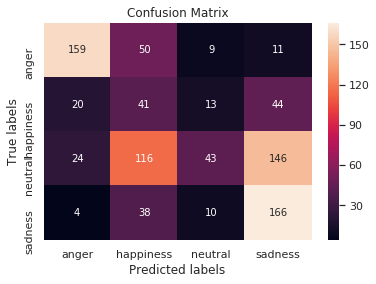


 Classification Report 
              precision    recall  f1-score   support

      anger       0.77      0.69      0.73       229
  happiness       0.17      0.35      0.23       118
    neutral       0.57      0.13      0.21       329
    sadness       0.45      0.76      0.57       218

avg / total       0.54      0.46      0.43       894
 

Train Epoch: 46 [0/3598 (0%)]	Loss: 1.059483

Train Epoch: 46 [640/3598 (18%)]	Loss: 1.105084

Train Epoch: 46 [1280/3598 (35%)]	Loss: 1.050379

Train Epoch: 46 [1920/3598 (53%)]	Loss: 0.933962

Train Epoch: 46 [2560/3598 (70%)]	Loss: 1.047824

Train Epoch: 46 [3200/3598 (88%)]	Loss: 1.190311


Train set: Average loss: 0.0175


Train Accuracy: 1847/3598 (51%)


Test set: Average loss: 0.0193, Accuracy: 373/894 (41%)



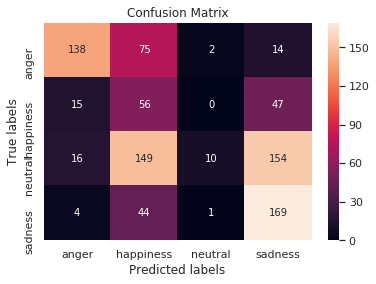


 Classification Report 
              precision    recall  f1-score   support

      anger       0.80      0.60      0.69       229
  happiness       0.17      0.47      0.25       118
    neutral       0.77      0.03      0.06       329
    sadness       0.44      0.78      0.56       218

avg / total       0.62      0.42      0.37       894
 

Train Epoch: 47 [0/3598 (0%)]	Loss: 1.115664

Train Epoch: 47 [640/3598 (18%)]	Loss: 1.232824

Train Epoch: 47 [1280/3598 (35%)]	Loss: 1.100035

Train Epoch: 47 [1920/3598 (53%)]	Loss: 1.064816

Train Epoch: 47 [2560/3598 (70%)]	Loss: 1.186240

Train Epoch: 47 [3200/3598 (88%)]	Loss: 1.264362


Train set: Average loss: 0.0175


Train Accuracy: 1771/3598 (49%)


Test set: Average loss: 0.0189, Accuracy: 413/894 (46%)



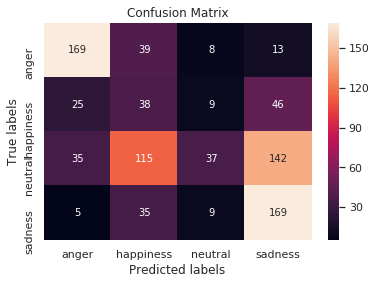


 Classification Report 
              precision    recall  f1-score   support

      anger       0.72      0.74      0.73       229
  happiness       0.17      0.32      0.22       118
    neutral       0.59      0.11      0.19       329
    sadness       0.46      0.78      0.57       218

avg / total       0.53      0.46      0.43       894
 

Train Epoch: 48 [0/3598 (0%)]	Loss: 1.000122

Train Epoch: 48 [640/3598 (18%)]	Loss: 1.196559

Train Epoch: 48 [1280/3598 (35%)]	Loss: 1.006820

Train Epoch: 48 [1920/3598 (53%)]	Loss: 1.156311

Train Epoch: 48 [2560/3598 (70%)]	Loss: 1.095634

Train Epoch: 48 [3200/3598 (88%)]	Loss: 1.088028


Train set: Average loss: 0.0174


Train Accuracy: 1836/3598 (51%)


Test set: Average loss: 0.0190, Accuracy: 404/894 (45%)



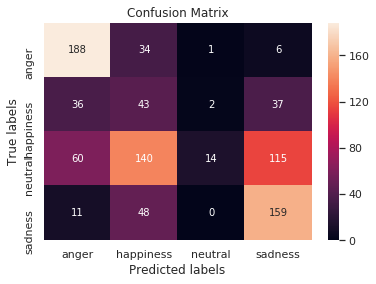


 Classification Report 
              precision    recall  f1-score   support

      anger       0.64      0.82      0.72       229
  happiness       0.16      0.36      0.22       118
    neutral       0.82      0.04      0.08       329
    sadness       0.50      0.73      0.59       218

avg / total       0.61      0.45      0.39       894
 

Train Epoch: 49 [0/3598 (0%)]	Loss: 1.308537

Train Epoch: 49 [640/3598 (18%)]	Loss: 0.947228

Train Epoch: 49 [1280/3598 (35%)]	Loss: 1.041078

Train Epoch: 49 [1920/3598 (53%)]	Loss: 1.140493

Train Epoch: 49 [2560/3598 (70%)]	Loss: 1.009519

Train Epoch: 49 [3200/3598 (88%)]	Loss: 1.162080


Train set: Average loss: 0.0175


Train Accuracy: 1795/3598 (49%)


Test set: Average loss: 0.0191, Accuracy: 379/894 (42%)



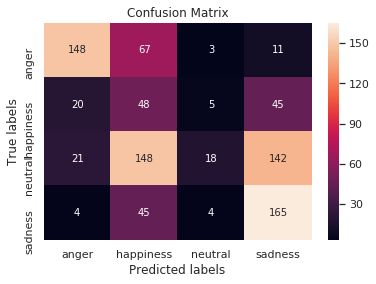


 Classification Report 
              precision    recall  f1-score   support

      anger       0.77      0.65      0.70       229
  happiness       0.16      0.41      0.23       118
    neutral       0.60      0.05      0.10       329
    sadness       0.45      0.76      0.57       218

avg / total       0.55      0.42      0.38       894
 

Train Epoch: 50 [0/3598 (0%)]	Loss: 1.050175

Train Epoch: 50 [640/3598 (18%)]	Loss: 0.969827

Train Epoch: 50 [1280/3598 (35%)]	Loss: 0.990996

Train Epoch: 50 [1920/3598 (53%)]	Loss: 1.144942

Train Epoch: 50 [2560/3598 (70%)]	Loss: 1.027439

Train Epoch: 50 [3200/3598 (88%)]	Loss: 1.247466


Train set: Average loss: 0.0175


Train Accuracy: 1825/3598 (50%)


Test set: Average loss: 0.0192, Accuracy: 386/894 (43%)



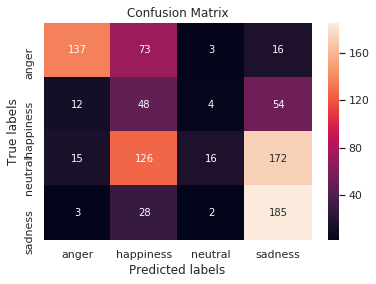


 Classification Report 
              precision    recall  f1-score   support

      anger       0.82      0.60      0.69       229
  happiness       0.17      0.41      0.24       118
    neutral       0.64      0.05      0.09       329
    sadness       0.43      0.85      0.57       218

avg / total       0.57      0.43      0.38       894
 

Train Epoch: 51 [0/3598 (0%)]	Loss: 0.968643

Train Epoch: 51 [640/3598 (18%)]	Loss: 1.210805

Train Epoch: 51 [1280/3598 (35%)]	Loss: 1.221697

Train Epoch: 51 [1920/3598 (53%)]	Loss: 1.181942

Train Epoch: 51 [2560/3598 (70%)]	Loss: 1.180927

Train Epoch: 51 [3200/3598 (88%)]	Loss: 1.132891


Train set: Average loss: 0.0175


Train Accuracy: 1809/3598 (50%)


Test set: Average loss: 0.0191, Accuracy: 399/894 (44%)



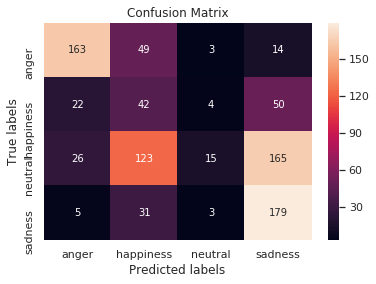


 Classification Report 
              precision    recall  f1-score   support

      anger       0.75      0.71      0.73       229
  happiness       0.17      0.36      0.23       118
    neutral       0.60      0.05      0.08       329
    sadness       0.44      0.82      0.57       218

avg / total       0.54      0.45      0.39       894
 

Train Epoch: 52 [0/3598 (0%)]	Loss: 1.103829

Train Epoch: 52 [640/3598 (18%)]	Loss: 1.083087

Train Epoch: 52 [1280/3598 (35%)]	Loss: 1.174736

Train Epoch: 52 [1920/3598 (53%)]	Loss: 1.093123

Train Epoch: 52 [2560/3598 (70%)]	Loss: 1.046220

Train Epoch: 52 [3200/3598 (88%)]	Loss: 1.100727


Train set: Average loss: 0.0173


Train Accuracy: 1847/3598 (51%)


Test set: Average loss: 0.0194, Accuracy: 379/894 (42%)



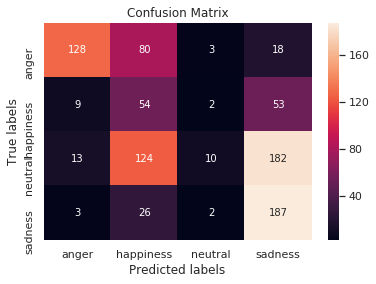


 Classification Report 
              precision    recall  f1-score   support

      anger       0.84      0.56      0.67       229
  happiness       0.19      0.46      0.27       118
    neutral       0.59      0.03      0.06       329
    sadness       0.42      0.86      0.57       218

avg / total       0.56      0.42      0.37       894
 

Train Epoch: 53 [0/3598 (0%)]	Loss: 1.098723

Train Epoch: 53 [640/3598 (18%)]	Loss: 1.125669

Train Epoch: 53 [1280/3598 (35%)]	Loss: 1.171888

Train Epoch: 53 [1920/3598 (53%)]	Loss: 1.192178

Train Epoch: 53 [2560/3598 (70%)]	Loss: 1.143417

Train Epoch: 53 [3200/3598 (88%)]	Loss: 1.015544


Train set: Average loss: 0.0174


Train Accuracy: 1844/3598 (51%)


Test set: Average loss: 0.0191, Accuracy: 399/894 (44%)



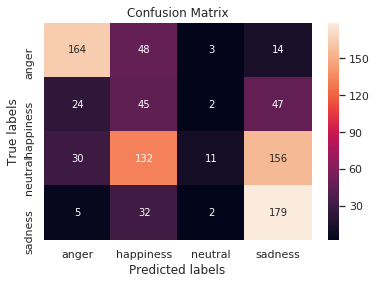


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.72      0.73       229
  happiness       0.18      0.38      0.24       118
    neutral       0.61      0.03      0.06       329
    sadness       0.45      0.82      0.58       218

avg / total       0.55      0.45      0.38       894
 

Train Epoch: 54 [0/3598 (0%)]	Loss: 1.183224

Train Epoch: 54 [640/3598 (18%)]	Loss: 1.081588

Train Epoch: 54 [1280/3598 (35%)]	Loss: 0.938685

Train Epoch: 54 [1920/3598 (53%)]	Loss: 1.321313

Train Epoch: 54 [2560/3598 (70%)]	Loss: 1.063451

Train Epoch: 54 [3200/3598 (88%)]	Loss: 1.001062


Train set: Average loss: 0.0173


Train Accuracy: 1837/3598 (51%)


Test set: Average loss: 0.0189, Accuracy: 393/894 (43%)



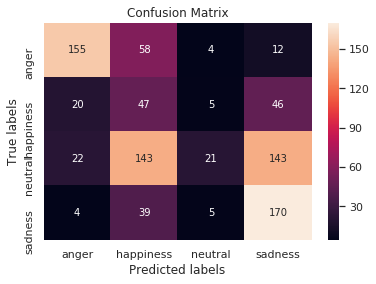


 Classification Report 
              precision    recall  f1-score   support

      anger       0.77      0.68      0.72       229
  happiness       0.16      0.40      0.23       118
    neutral       0.60      0.06      0.12       329
    sadness       0.46      0.78      0.58       218

avg / total       0.55      0.44      0.40       894
 

Train Epoch: 55 [0/3598 (0%)]	Loss: 1.187657

Train Epoch: 55 [640/3598 (18%)]	Loss: 1.029589

Train Epoch: 55 [1280/3598 (35%)]	Loss: 1.059353

Train Epoch: 55 [1920/3598 (53%)]	Loss: 1.230958

Train Epoch: 55 [2560/3598 (70%)]	Loss: 1.107023

Train Epoch: 55 [3200/3598 (88%)]	Loss: 1.153008


Train set: Average loss: 0.0174


Train Accuracy: 1853/3598 (51%)


Test set: Average loss: 0.0194, Accuracy: 393/894 (43%)



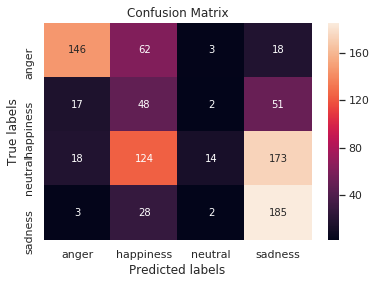


 Classification Report 
              precision    recall  f1-score   support

      anger       0.79      0.64      0.71       229
  happiness       0.18      0.41      0.25       118
    neutral       0.67      0.04      0.08       329
    sadness       0.43      0.85      0.57       218

avg / total       0.58      0.44      0.38       894
 

Train Epoch: 56 [0/3598 (0%)]	Loss: 1.000519

Train Epoch: 56 [640/3598 (18%)]	Loss: 1.079794

Train Epoch: 56 [1280/3598 (35%)]	Loss: 1.053363

Train Epoch: 56 [1920/3598 (53%)]	Loss: 1.079866

Train Epoch: 56 [2560/3598 (70%)]	Loss: 0.958779

Train Epoch: 56 [3200/3598 (88%)]	Loss: 1.043053


Train set: Average loss: 0.0173


Train Accuracy: 1804/3598 (50%)


Test set: Average loss: 0.0188, Accuracy: 420/894 (46%)



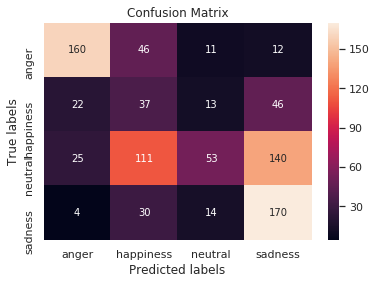


 Classification Report 
              precision    recall  f1-score   support

      anger       0.76      0.70      0.73       229
  happiness       0.17      0.31      0.22       118
    neutral       0.58      0.16      0.25       329
    sadness       0.46      0.78      0.58       218

avg / total       0.54      0.47      0.45       894
 

Train Epoch: 57 [0/3598 (0%)]	Loss: 1.075723

Train Epoch: 57 [640/3598 (18%)]	Loss: 1.112837

Train Epoch: 57 [1280/3598 (35%)]	Loss: 1.042729

Train Epoch: 57 [1920/3598 (53%)]	Loss: 1.149778

Train Epoch: 57 [2560/3598 (70%)]	Loss: 1.070321

Train Epoch: 57 [3200/3598 (88%)]	Loss: 1.068892


Train set: Average loss: 0.0173


Train Accuracy: 1840/3598 (51%)


Test set: Average loss: 0.0192, Accuracy: 399/894 (44%)



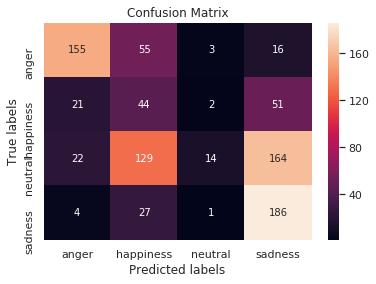


 Classification Report 
              precision    recall  f1-score   support

      anger       0.77      0.68      0.72       229
  happiness       0.17      0.37      0.24       118
    neutral       0.70      0.04      0.08       329
    sadness       0.45      0.85      0.59       218

avg / total       0.59      0.45      0.39       894
 

Train Epoch: 58 [0/3598 (0%)]	Loss: 1.041197

Train Epoch: 58 [640/3598 (18%)]	Loss: 1.037717

Train Epoch: 58 [1280/3598 (35%)]	Loss: 0.991398

Train Epoch: 58 [1920/3598 (53%)]	Loss: 1.152087

Train Epoch: 58 [2560/3598 (70%)]	Loss: 1.040056

Train Epoch: 58 [3200/3598 (88%)]	Loss: 0.942110


Train set: Average loss: 0.0172


Train Accuracy: 1876/3598 (52%)


Test set: Average loss: 0.0187, Accuracy: 409/894 (45%)



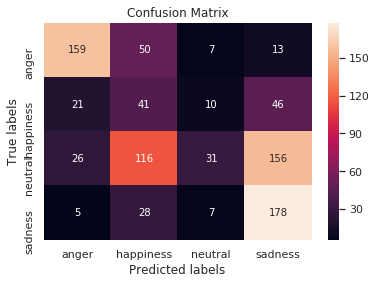


 Classification Report 
              precision    recall  f1-score   support

      anger       0.75      0.69      0.72       229
  happiness       0.17      0.35      0.23       118
    neutral       0.56      0.09      0.16       329
    sadness       0.45      0.82      0.58       218

avg / total       0.53      0.46      0.42       894
 

Train Epoch: 59 [0/3598 (0%)]	Loss: 1.073676

Train Epoch: 59 [640/3598 (18%)]	Loss: 1.066014

Train Epoch: 59 [1280/3598 (35%)]	Loss: 1.039907

Train Epoch: 59 [1920/3598 (53%)]	Loss: 1.207701

Train Epoch: 59 [2560/3598 (70%)]	Loss: 1.092697

Train Epoch: 59 [3200/3598 (88%)]	Loss: 1.175950


Train set: Average loss: 0.0172


Train Accuracy: 1840/3598 (51%)


Test set: Average loss: 0.0191, Accuracy: 391/894 (43%)



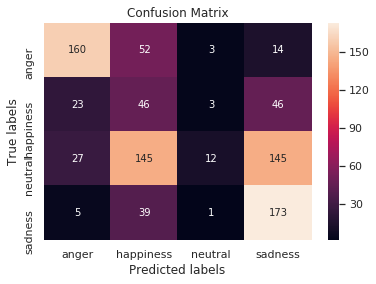


 Classification Report 
              precision    recall  f1-score   support

      anger       0.74      0.70      0.72       229
  happiness       0.16      0.39      0.23       118
    neutral       0.63      0.04      0.07       329
    sadness       0.46      0.79      0.58       218

avg / total       0.56      0.44      0.38       894
 

Train Epoch: 60 [0/3598 (0%)]	Loss: 1.121625

Train Epoch: 60 [640/3598 (18%)]	Loss: 1.145427

Train Epoch: 60 [1280/3598 (35%)]	Loss: 1.089833

Train Epoch: 60 [1920/3598 (53%)]	Loss: 0.981921

Train Epoch: 60 [2560/3598 (70%)]	Loss: 1.136424

Train Epoch: 60 [3200/3598 (88%)]	Loss: 1.020290


Train set: Average loss: 0.0172


Train Accuracy: 1914/3598 (53%)


Test set: Average loss: 0.0192, Accuracy: 369/894 (41%)



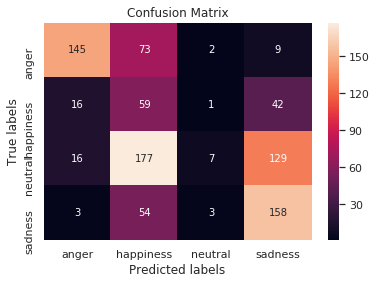


 Classification Report 
              precision    recall  f1-score   support

      anger       0.81      0.63      0.71       229
  happiness       0.16      0.50      0.25       118
    neutral       0.54      0.02      0.04       329
    sadness       0.47      0.72      0.57       218

avg / total       0.54      0.41      0.37       894
 



In [282]:
history = []
n_epoch = 61
for epoch in range(1, n_epoch):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
#     plateau_scheduler.step(test_loss)
    
    history.append([train_loss, train_acc, test_loss, test_acc])

In [283]:
history_df = pd.DataFrame(history, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [284]:
history_df["epoch"] = [x for x in range(1, n_epoch)]

In [285]:
history_df

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.023495,25,0.021662,35,1
1,0.022096,24,0.021690,29,2
2,0.022019,26,0.021665,34,3
3,0.021894,28,0.021671,30,4
4,0.021895,27,0.021656,29,5
5,0.021794,28,0.021603,30,6
6,0.021718,33,0.021612,24,7
7,0.021443,33,0.021470,32,8
8,0.021032,34,0.021170,34,9
9,0.020572,38,0.020917,34,10


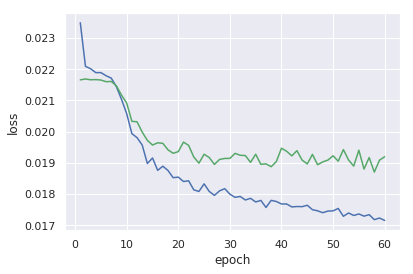

In [286]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_loss', data=history_df, color='g')
plt.ylabel("loss")
plt.show()

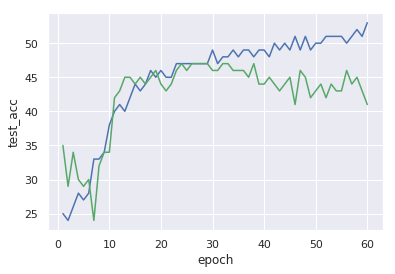

In [287]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_acc', data=history_df, color='g')
plt.show()

In [142]:
torch.save(model, model_save_path + '/CNN_unfreeze.pth')

In [143]:
model = torch.load(model_save_path + '/CNN_unfreeze.pth')

In [144]:
for param in model.parameters():
    param.requires_grad = False

In [145]:
ct = 0
for child in model.children():
    ct += 1
#     print(ct)
    if ct > 3:
        print("child", ct, "was not frozen")
        for param in child.parameters():
            param.requires_grad = True
    else:
        print("child", ct, "was frozen")

child 1 was frozen
child 2 was frozen
child 3 was frozen
child 4 was not frozen
child 5 was not frozen
child 6 was not frozen


In [146]:
# for param in model.parameters():
#     param.requires_grad = True

In [147]:
# optimizer = optim.Adam(model.parameters(), lr=0.003)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [148]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

25,716,260 total parameters.
25,692,676 training parameters.


In [112]:
model = model.to(device)

Train Epoch: 1 [0/3598 (0%)]	Loss: 0.785847

Train Epoch: 1 [640/3598 (18%)]	Loss: 0.767017

Train Epoch: 1 [1280/3598 (35%)]	Loss: 0.903060

Train Epoch: 1 [1920/3598 (53%)]	Loss: 0.674861

Train Epoch: 1 [2560/3598 (70%)]	Loss: 0.920111

Train Epoch: 1 [3200/3598 (88%)]	Loss: 0.666323


Train set: Average loss: 0.0130


Train Accuracy: 2342/3598 (65%)


Test set: Average loss: 0.0184, Accuracy: 480/894 (53%)



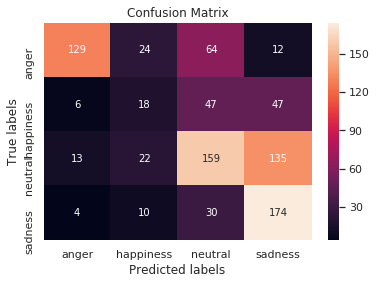


 Classification Report 
              precision    recall  f1-score   support

      anger       0.85      0.56      0.68       229
  happiness       0.24      0.15      0.19       118
    neutral       0.53      0.48      0.51       329
    sadness       0.47      0.80      0.59       218

avg / total       0.56      0.54      0.53       894
 

Train Epoch: 2 [0/3598 (0%)]	Loss: 0.839202

Train Epoch: 2 [640/3598 (18%)]	Loss: 0.606037

Train Epoch: 2 [1280/3598 (35%)]	Loss: 0.870353

Train Epoch: 2 [1920/3598 (53%)]	Loss: 0.642848

Train Epoch: 2 [2560/3598 (70%)]	Loss: 0.812828

Train Epoch: 2 [3200/3598 (88%)]	Loss: 0.858081


Train set: Average loss: 0.0127


Train Accuracy: 2365/3598 (65%)


Test set: Average loss: 0.0184, Accuracy: 480/894 (53%)



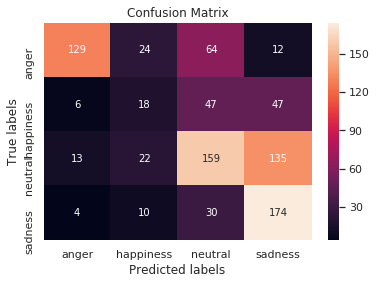


 Classification Report 
              precision    recall  f1-score   support

      anger       0.85      0.56      0.68       229
  happiness       0.24      0.15      0.19       118
    neutral       0.53      0.48      0.51       329
    sadness       0.47      0.80      0.59       218

avg / total       0.56      0.54      0.53       894
 

Train Epoch: 3 [0/3598 (0%)]	Loss: 0.804351

Train Epoch: 3 [640/3598 (18%)]	Loss: 0.836965

Train Epoch: 3 [1280/3598 (35%)]	Loss: 0.534733

Train Epoch: 3 [1920/3598 (53%)]	Loss: 0.667881

Train Epoch: 3 [2560/3598 (70%)]	Loss: 0.835175

Train Epoch: 3 [3200/3598 (88%)]	Loss: 0.892154


Train set: Average loss: 0.0129


Train Accuracy: 2351/3598 (65%)


Test set: Average loss: 0.0183, Accuracy: 480/894 (53%)



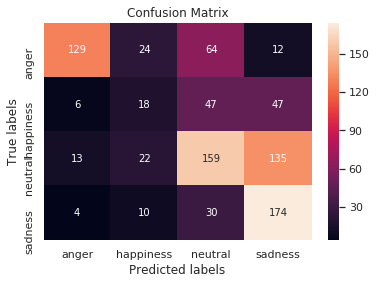


 Classification Report 
              precision    recall  f1-score   support

      anger       0.85      0.56      0.68       229
  happiness       0.24      0.15      0.19       118
    neutral       0.53      0.48      0.51       329
    sadness       0.47      0.80      0.59       218

avg / total       0.56      0.54      0.53       894
 

Train Epoch: 4 [0/3598 (0%)]	Loss: 0.782922

Train Epoch: 4 [640/3598 (18%)]	Loss: 0.818788

Train Epoch: 4 [1280/3598 (35%)]	Loss: 1.003484

Train Epoch: 4 [1920/3598 (53%)]	Loss: 0.780468

Train Epoch: 4 [2560/3598 (70%)]	Loss: 0.787514

Train Epoch: 4 [3200/3598 (88%)]	Loss: 0.797987


Train set: Average loss: 0.0130


Train Accuracy: 2327/3598 (64%)


Test set: Average loss: 0.0183, Accuracy: 480/894 (53%)



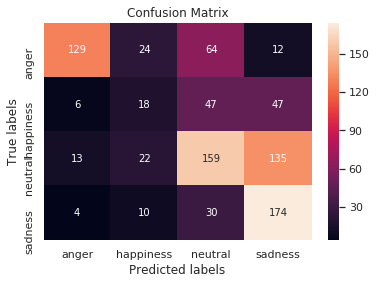


 Classification Report 
              precision    recall  f1-score   support

      anger       0.85      0.56      0.68       229
  happiness       0.24      0.15      0.19       118
    neutral       0.53      0.48      0.51       329
    sadness       0.47      0.80      0.59       218

avg / total       0.56      0.54      0.53       894
 

Train Epoch: 5 [0/3598 (0%)]	Loss: 0.668884

Train Epoch: 5 [640/3598 (18%)]	Loss: 0.674814

Train Epoch: 5 [1280/3598 (35%)]	Loss: 0.865727

Train Epoch: 5 [1920/3598 (53%)]	Loss: 0.779878

Train Epoch: 5 [2560/3598 (70%)]	Loss: 1.037760

Train Epoch: 5 [3200/3598 (88%)]	Loss: 0.808680


Train set: Average loss: 0.0128


Train Accuracy: 2347/3598 (65%)


Test set: Average loss: 0.0183, Accuracy: 480/894 (53%)



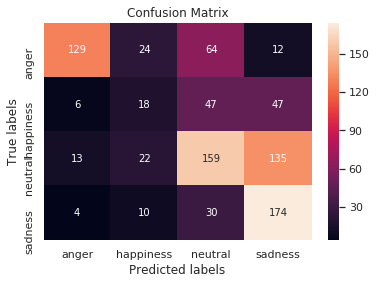


 Classification Report 
              precision    recall  f1-score   support

      anger       0.85      0.56      0.68       229
  happiness       0.24      0.15      0.19       118
    neutral       0.53      0.48      0.51       329
    sadness       0.47      0.80      0.59       218

avg / total       0.56      0.54      0.53       894
 



In [113]:
history_unfreeze = []
n_epoch_unfrz = 6
for epoch in range(1, n_epoch_unfrz):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
    history_unfreeze.append([train_loss, train_acc, test_loss, test_acc])

In [219]:
history_df_unfrz = pd.DataFrame(history_unfreeze, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [151]:
history_df_unfrz["epoch"] = [x for x in range(n_epoch, n_epoch + n_epoch_unfrz - 1)]

In [152]:
history_df_unfrz

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.012954,65,0.018355,53,41
1,0.012663,65,0.018351,53,42
2,0.012860,65,0.018348,53,43
3,0.013022,64,0.018344,53,44
4,0.012781,65,0.018340,53,45


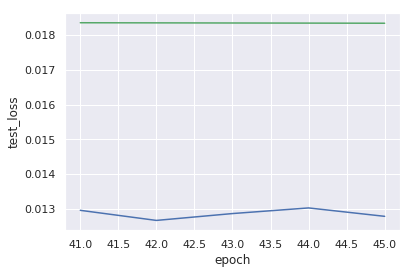

In [117]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df_unfrz, color='b')
sns.lineplot(x='epoch', y='test_loss', data=history_df_unfrz, color='g')
plt.show()
# plt.xticks()

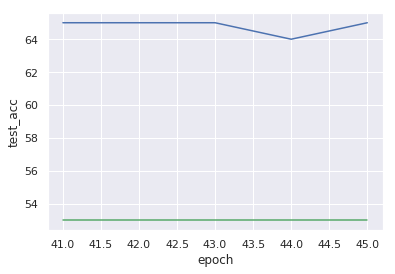

In [118]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df_unfrz, color='b')
sns.lineplot(x='epoch', y='test_acc', data=history_df_unfrz, color='g')
plt.show()
# plt.xticks()

In [48]:
torch.save(model, model_save_path + '/ResNet34_UnFreeze_Weights.pth')

In [49]:
history_total = pd.concat([history_df, history_df_unfrz])

In [50]:
history_total

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.021700,30,0.020424,42,1
1,0.020704,39,0.019975,40,2
2,0.019978,41,0.019231,46,3
3,0.019635,44,0.018700,48,4
4,0.019189,47,0.018448,47,5
5,0.019029,45,0.018345,47,6
6,0.018708,47,0.017965,49,7
7,0.018301,48,0.017837,48,8
8,0.018318,48,0.017627,51,9
9,0.018038,49,0.017490,50,10


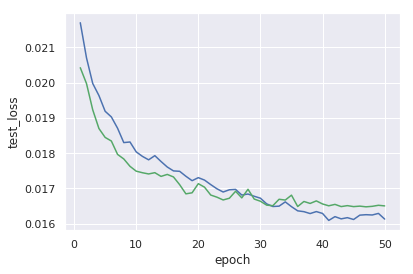

In [51]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_total, color='b')
sns.lineplot(x='epoch', y='test_loss', data=history_total, color='g')
plt.show()
# plt.xticks()

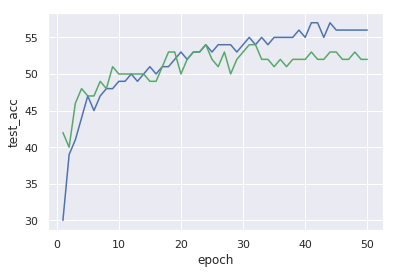

In [52]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_total, color='b')
sns.lineplot(x='epoch', y='test_acc', data=history_total, color='g')
plt.show()
# plt.xticks()